## Analysis for Physically Implausible Decay of Diffusion Signals (PIDS)

In [139]:
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable


In [140]:
import os
import mat73
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import PIDS_functions as pf
import skimage
from skimage import morphology
import cv2
import sys 

In [141]:
# Change the following line for a new case
#Patient 33
#data_address = 'C://Users//AM//Desktop//Work//Shared with trishna//pat033//master.mat'
#data_address2 = 'C://Users//AM//Desktop//Work//Shared with trishna//pat033//master33_output.mat'

#Patient 29
#data_address = 'C://Users//AM//Desktop//Work//Shared with trishna//pat29//pat029_sl_9_hybridSortedInput_mb.mat'
#data_address2 = 'C://Users//AM//Desktop//Work//Shared with trishna//pat29//master29_md_output.mat'

#Patient 65  
#data_address = 'C://Users//AM//Desktop//Work//Shared with trishna//pat065//master.mat'
#data_address2 = 'C://Users//AM//Desktop//Work//Shared with trishna//pat065//master65_output.mat'

#Patient 83
data_address = 'C://Users//AM//Desktop//Work//Shared with trishna//pat083//master.mat'
data_address2 = 'C://Users//AM//Desktop//Work//Shared with trishna//pat083//master83_output.mat'

In [142]:
print('Loading data')
try:
    data = sio.loadmat(data_address)
except NotImplementedError:
    data = mat73.loadmat(data_address)
print('Data loaded')
print('Loading data')
try:
    data2 = sio.loadmat(data_address2)
except NotImplementedError:
    data2 = mat73.loadmat(data_address2)
print('Data loaded')

Loading data
Data loaded
Loading data
Data loaded


In [143]:
print(pf.color.BOLD + pf.color.GREEN + 'The variables in this data file are:' + pf.color.END)
for f in data.keys():
    try:
        print(f'{f} : {data[f].shape}')
    except:
        continue

The variables in this data file are:
DCE : (192, 192, 53, 60)
T1 : (400, 400, 34)
T2 : (576, 576, 34)
T2_3D : (288, 288, 145)
TE : (4,)
TE_norm : (4,)
areScaled : ()
b : (4,)
b0 : (128, 128, 34)
b1 : (128, 128, 34, 6)
b2 : (128, 128, 34, 6)
b3 : (128, 128, 34, 12)
b4 : (128, 128, 34, 18)
benign_mask : (128, 128, 34)
cancer_mask : (128, 128, 34)
hybrid_data : (128, 128, 34, 4, 4)
noise_mask : (128, 128, 34)
numSlices : ()
raw : (128, 128, 34, 5, 3, 6)
scanned_image : (288, 288, 145)


In [144]:
b_values = data['b']
TE_values = data['TE']
TE_norm = data['TE_norm']
hybrid_data = data['hybrid_data']
cancer_mask = data['cancer_mask']
benign_mask = data['benign_mask']
#Hybrid_raw not available in P033 
#hybrid_raw = data['hybrid_raw']
registered_hybrid = data2['registered_hybrid']

In [145]:
#hybrid_raw_reshaped = hybrid_data.copy()
#for b in range(4):
#    for te in range(4):
#        hybrid_raw_reshaped[:, :, :, b, te] = np.mean(hybrid_raw[b][te], -1) if b else hybrid_raw[b][te]

Calculating PIDS for slice 15


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

12.0


  0%|          | 0/128 [00:00<?, ?it/s]

Calculating PIDS for slice 16


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

14.0


  0%|          | 0/128 [00:00<?, ?it/s]

Calculating PIDS for slice 17


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

20.0


  0%|          | 0/128 [00:00<?, ?it/s]

Calculating PIDS for slice 18


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

31.0


  0%|          | 0/128 [00:00<?, ?it/s]

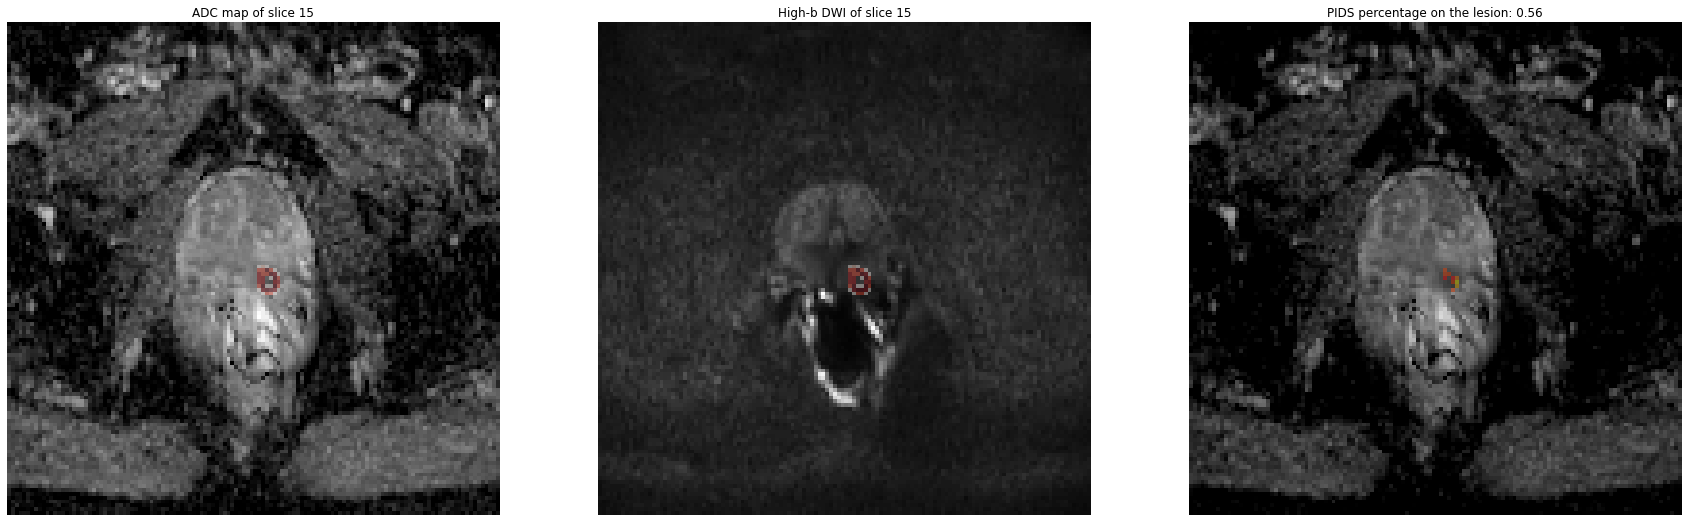

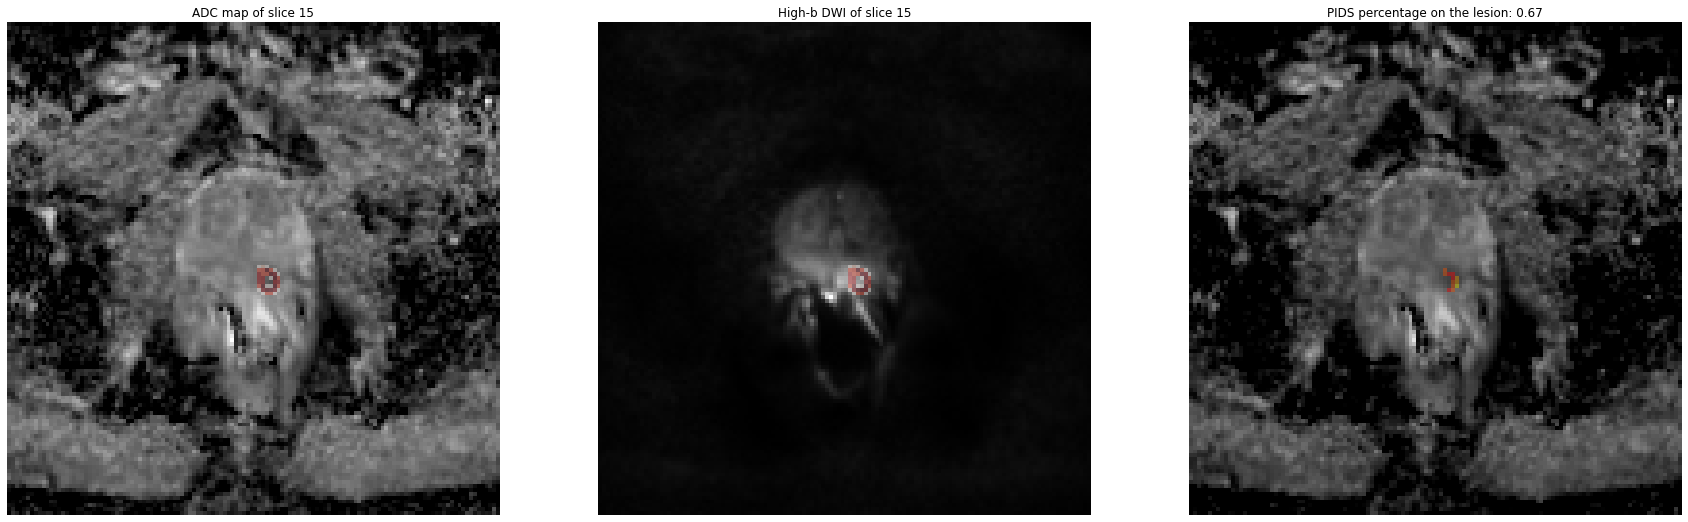

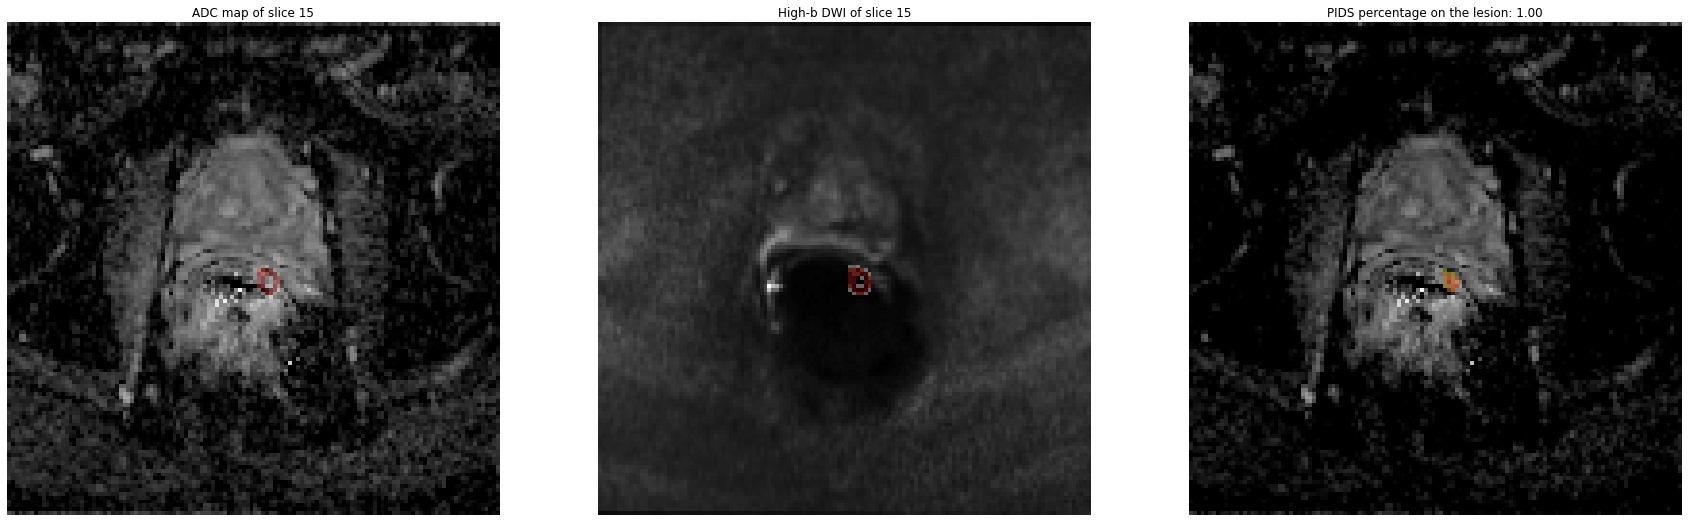

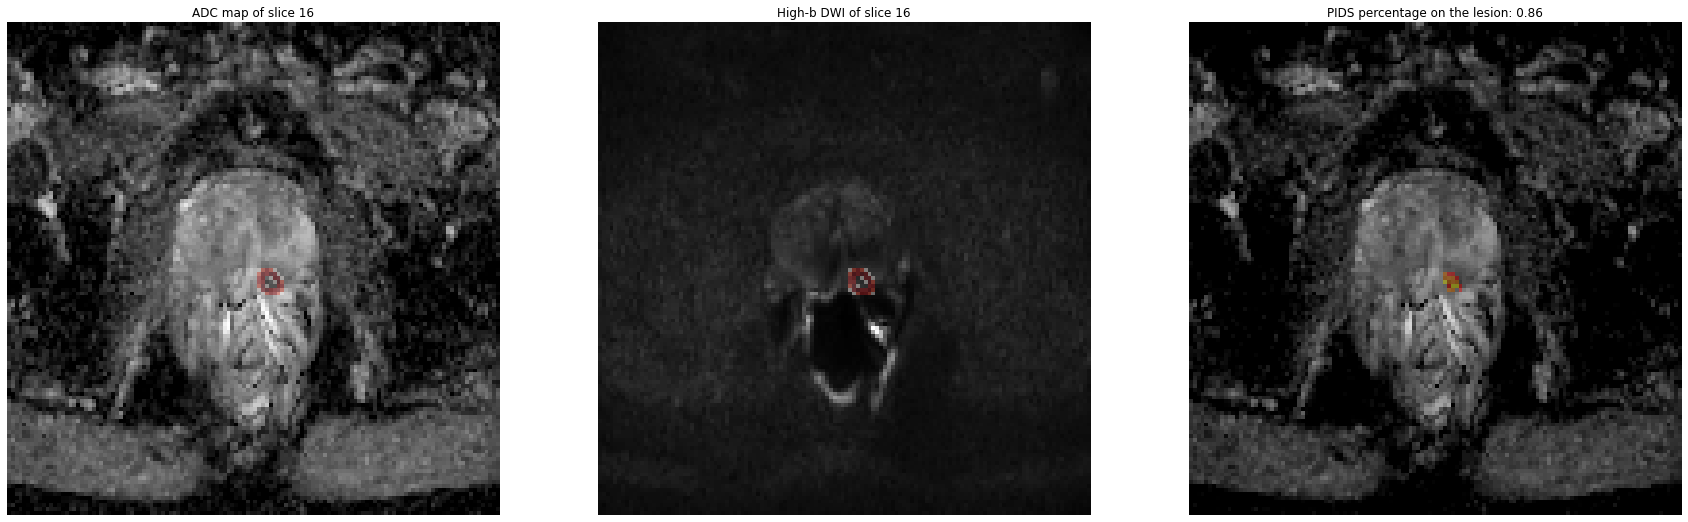

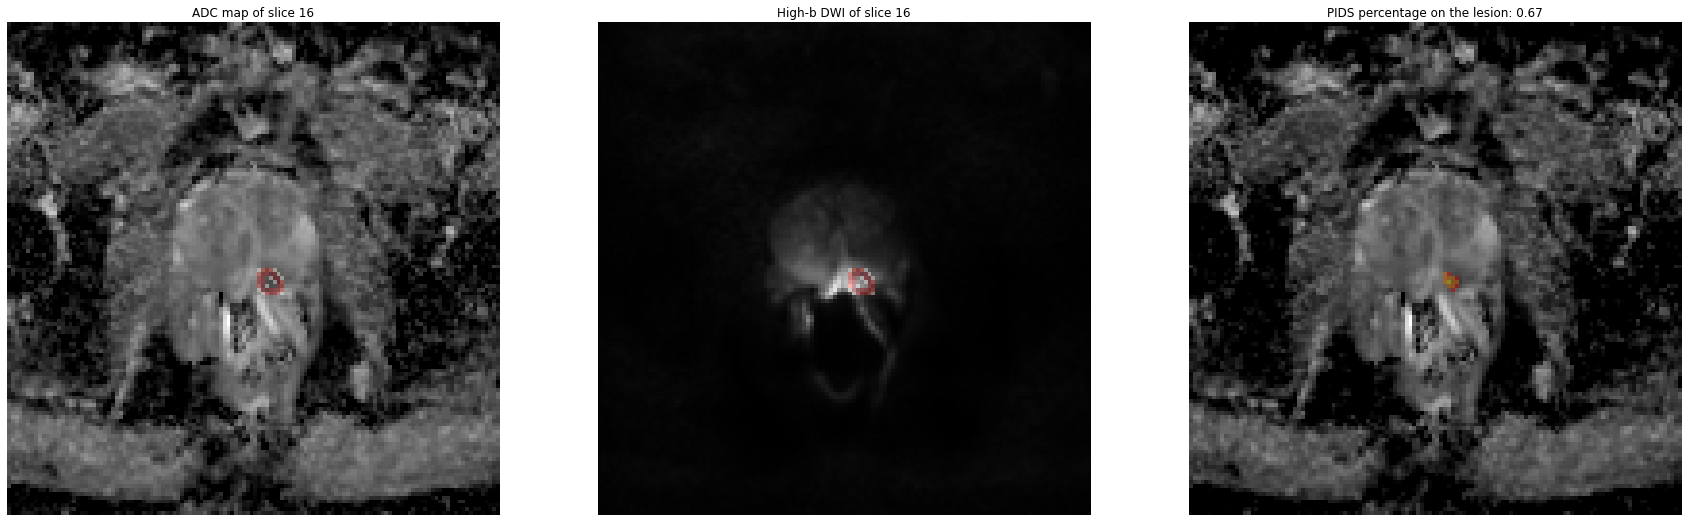

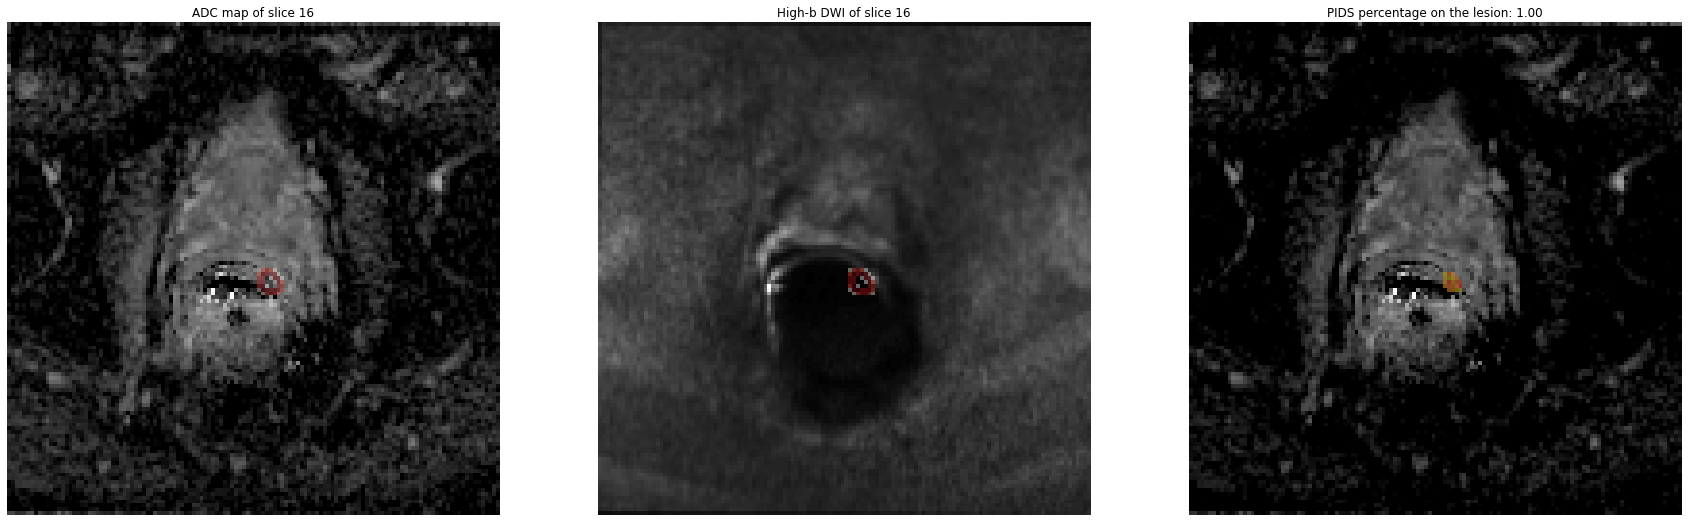

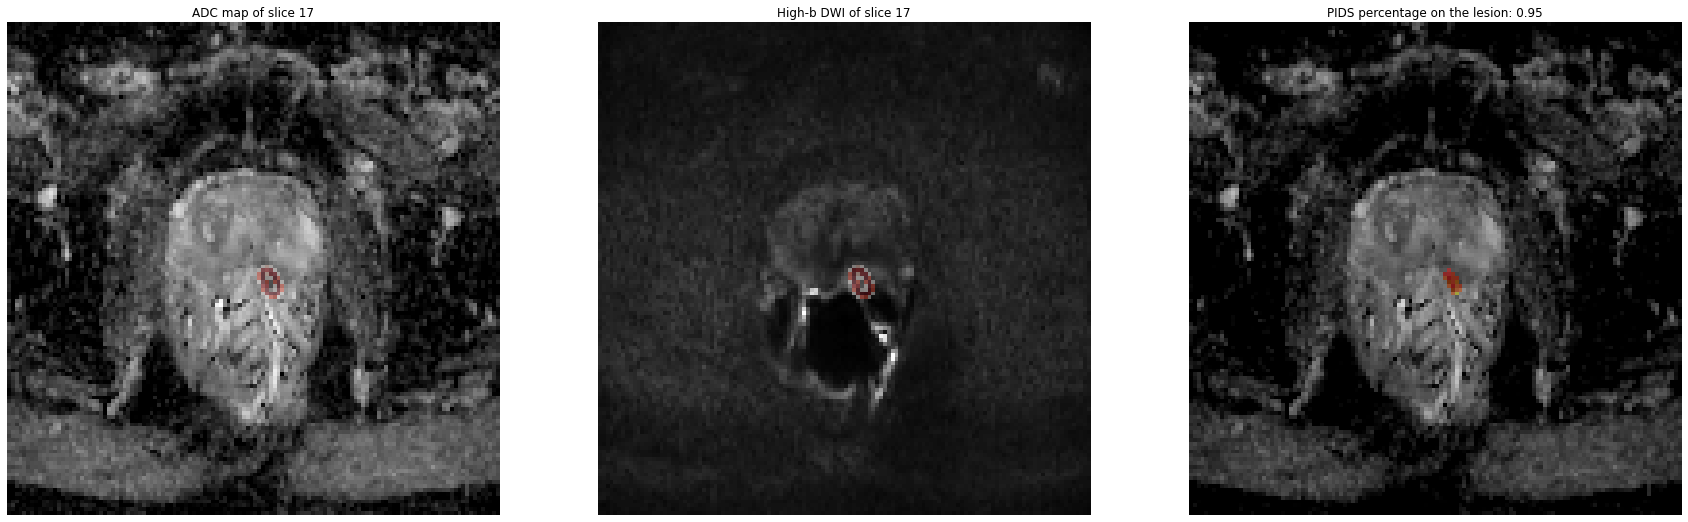

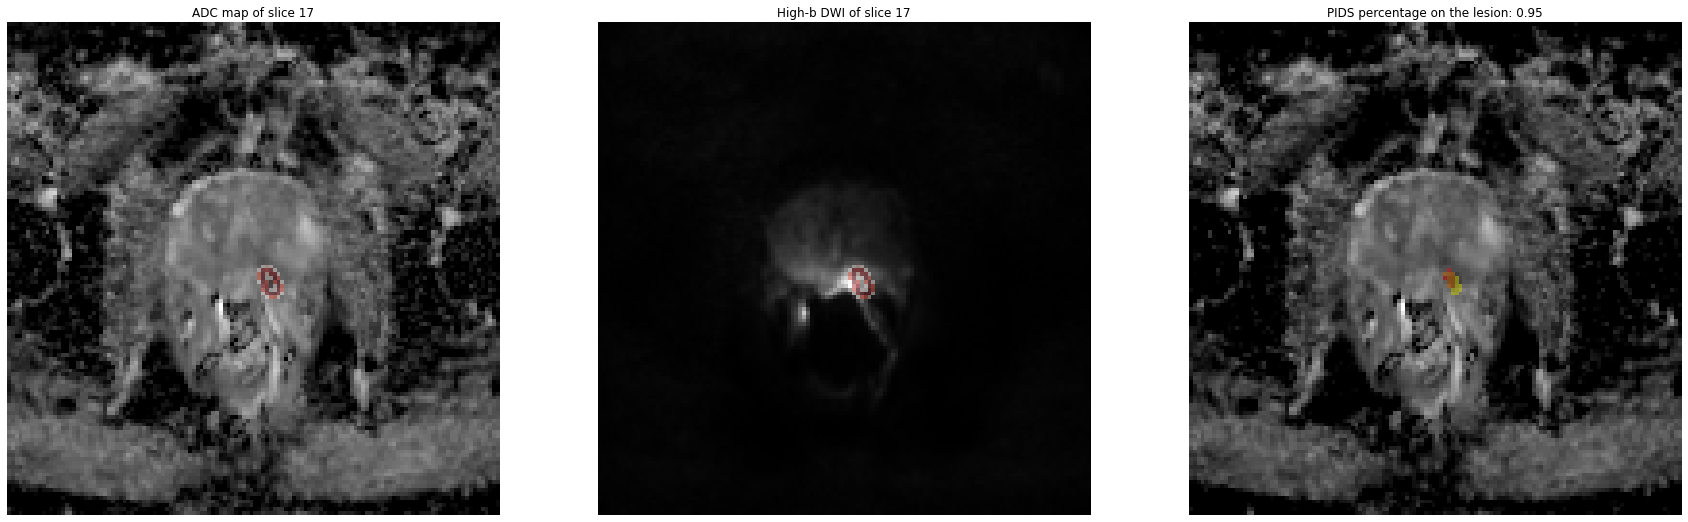

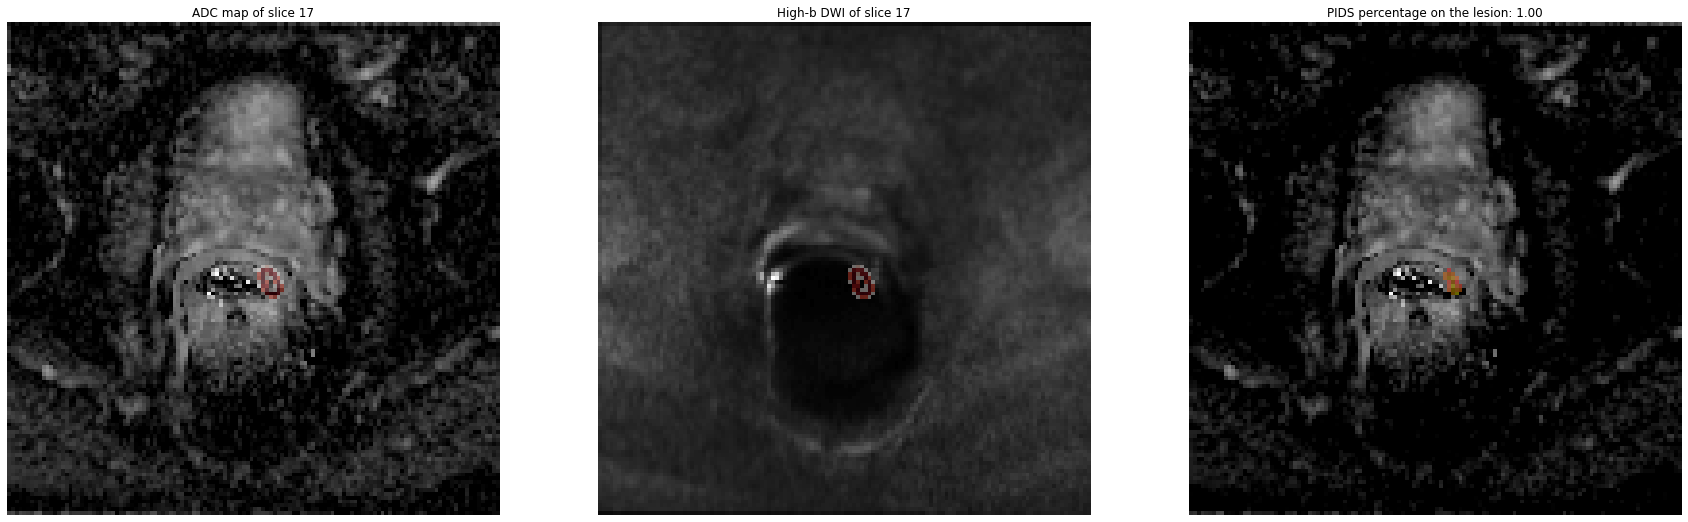

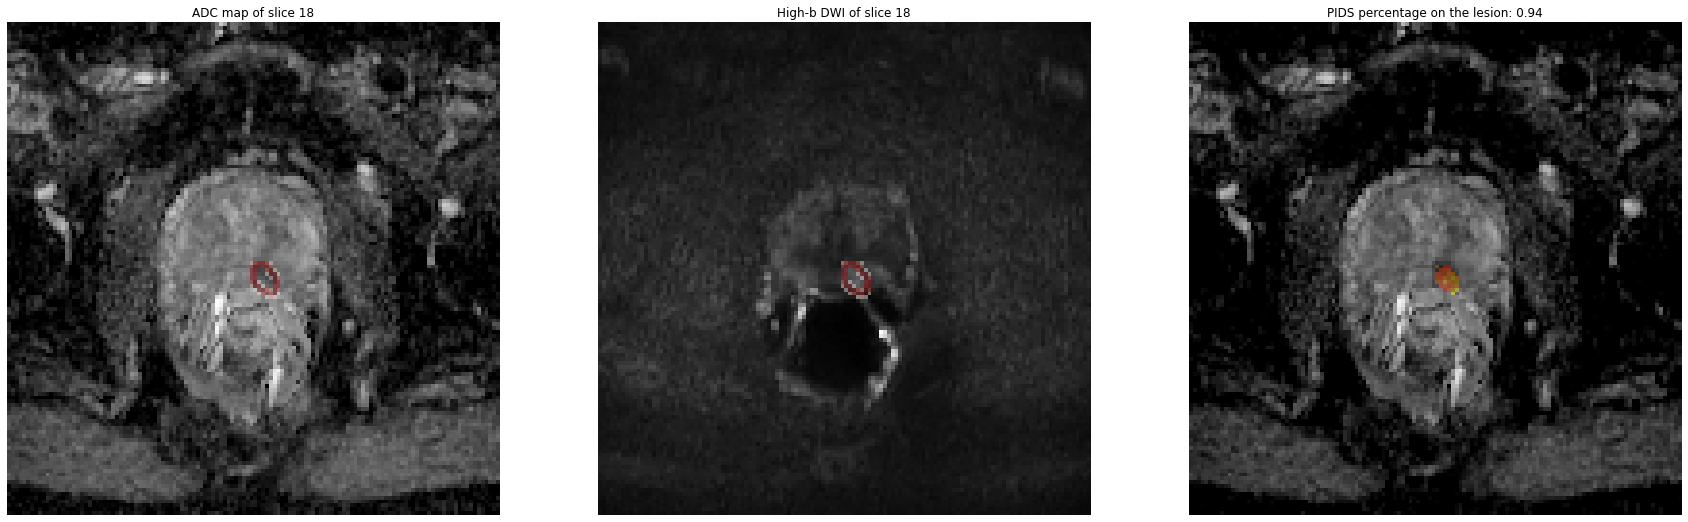

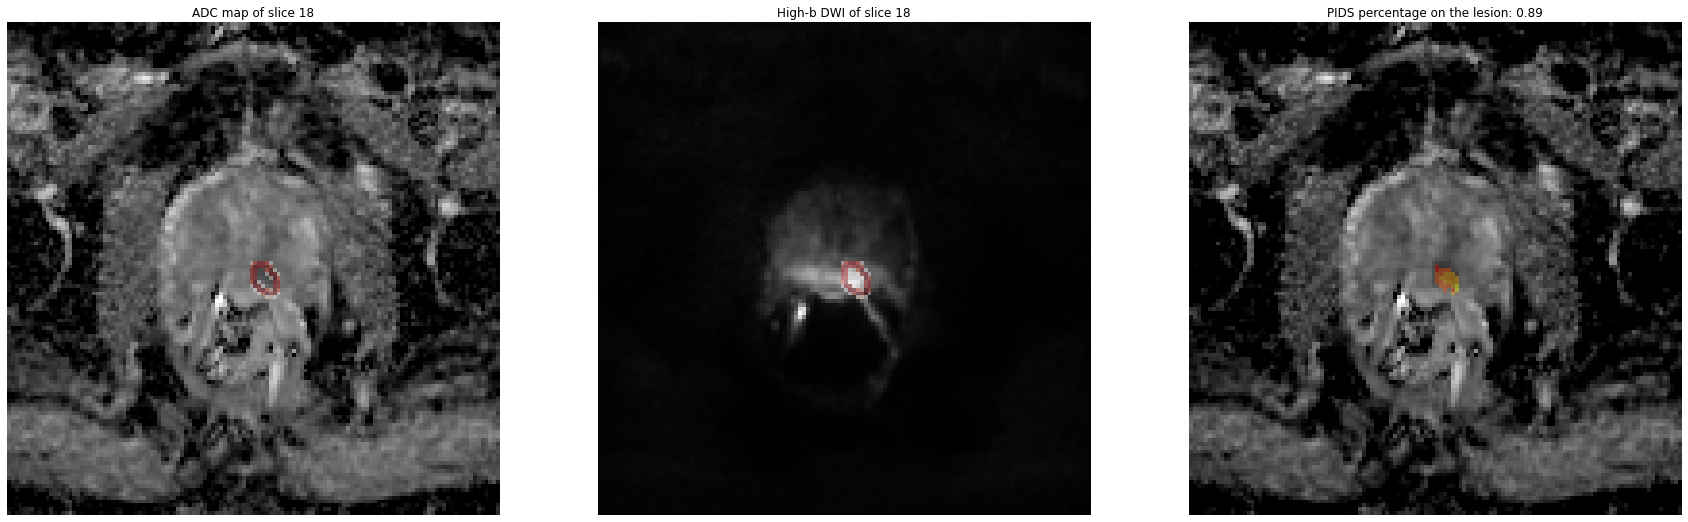

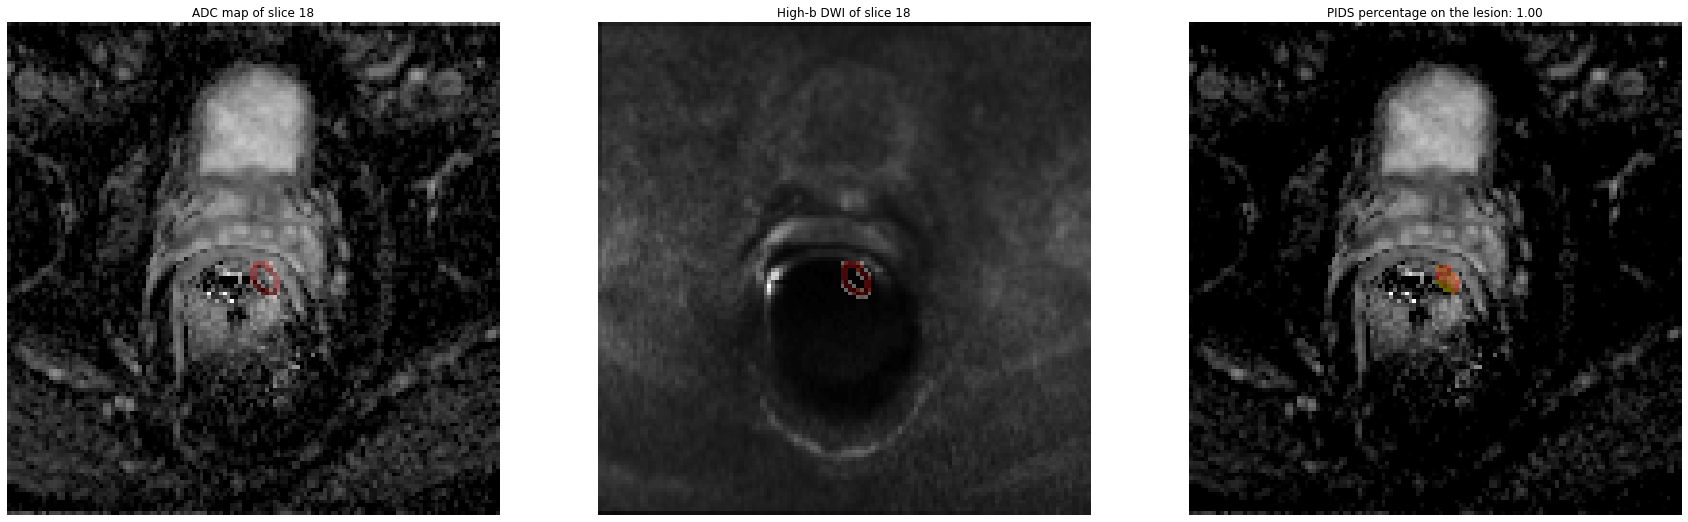

In [146]:
for sliceIndex in range(hybrid_data.shape[2]):
    if np.sum(cancer_mask[:, :, sliceIndex].flatten()):
        print(f'Calculating PIDS for slice {sliceIndex+1}')
        slicedata = np.squeeze(hybrid_data[:, :, sliceIndex, :, :])
        adc_map = pf.ADC_slice(b_values, hybrid_data[:,:, sliceIndex, :, 0])
        PIDS_1, PIDS_2, PIDS_3, PIDS_4 = pf.detect_PIDS_slice(b_values, hybrid_data[:,:, sliceIndex, :, :])
        fig, ax = plt.subplots(1,3, figsize = (30,10))
        ax[0].imshow(adc_map, cmap='gray')
        ax[0].set_title(f"ADC map of slice {sliceIndex + 1}")
        ax[0].axis('off')
        cancer = skimage.filters.sobel(cancer_mask[:, :, sliceIndex])
        cancer[cancer==0] = np.nan
        ax[0].imshow(cancer, cmap='Reds',alpha = 0.4)
        ax[0].axis('off')


        ax[1].imshow(hybrid_data[:,:, sliceIndex, 3, 0], cmap='gray')
        ax[1].set_title(f"High-b DWI of slice {sliceIndex + 1}")
        ax[1].axis('off')
        ax[1].imshow(cancer, cmap='Reds',alpha = 0.4)
        ax[1].axis('off')

        ax[2].imshow(adc_map, cmap='gray', vmin=0.3, vmax=3)
        ax[2].axis('off')

        PIDS = PIDS_1.astype(float) + PIDS_2.astype(float)
        for i in range(0,4):
            for j in range(0,3):
                PIDS += PIDS_3[:,:,i, j].astype(float)
                PIDS += PIDS_4[:,:,i, j].astype(float)
        num_cancer_voxels = cancer_mask[:, :, sliceIndex].sum()
        mask = PIDS*cancer_mask[:, :, sliceIndex]
        mask = mask.astype(float)
        num_PIDS = (mask>0).astype(float).sum()
        #print(num_PIDS)
        mask[mask==0] = np.nan
        ax[2].imshow(mask, cmap='autumn',alpha = 0.4)
        ax[2].axis('off')
        ax[2].set_title(f"PIDS percentage on the lesion: {num_PIDS/num_cancer_voxels:.2f}")

        slicedata = np.squeeze(hybrid_raw_reshaped[:, :, sliceIndex, :, :])
        adc_map = pf.ADC_slice(b_values, hybrid_raw_reshaped[:,:, sliceIndex, :, 0])
        PIDS_1, PIDS_2, PIDS_3, PIDS_4 = pf.detect_PIDS_slice(b_values, hybrid_raw_reshaped[:,:, sliceIndex, :, :])
        #print(PIDS_1)
        #print(PIDS_2)
        #print(PIDS_3)
        #print(PIDS_4)
        fig, ax = plt.subplots(1,3, figsize = (30,10))
        ax[0].imshow(adc_map, cmap='gray')
        ax[0].set_title(f"ADC map of slice {sliceIndex + 1}")
        ax[0].axis('off')
        cancer = skimage.filters.sobel(cancer_mask[:, :, sliceIndex])
        cancer[cancer==0] = np.nan
        ax[0].imshow(cancer, cmap='Reds',alpha = 0.4)
        ax[0].axis('off')


        ax[1].imshow(hybrid_raw_reshaped[:,:, sliceIndex, 3, 0], cmap='gray')
        ax[1].set_title(f"High-b DWI of slice {sliceIndex + 1}")
        ax[1].axis('off')
        ax[1].imshow(cancer, cmap='Reds',alpha = 0.4)
        ax[1].axis('off')

        ax[2].imshow(adc_map, cmap='gray', vmin=0.3, vmax=3)
        ax[2].axis('off')

        PIDS = PIDS_1.astype(float) + PIDS_2.astype(float)
        for i in range(0,4):
            for j in range(0,3):
                PIDS += PIDS_3[:,:,i, j].astype(float)
                PIDS += PIDS_4[:,:,i, j].astype(float)
        num_cancer_voxels = cancer_mask[:, :, sliceIndex].sum()
        mask = PIDS*cancer_mask[:, :, sliceIndex]
        mask = mask.astype(float)
        num_PIDS = (mask>0).astype(float).sum()
        print(num_PIDS)
        mask[mask==0] = np.nan
        ax[2].imshow(mask, cmap='autumn',alpha = 0.4)
        ax[2].axis('off')
        ax[2].set_title(f"PIDS percentage on the lesion: {num_PIDS/num_cancer_voxels:.2f}")

        slicedata = np.squeeze(registered_hybrid[:, :, sliceIndex, :, :])
        adc_map = pf.ADC_slice(b_values, registered_hybrid[:,:, sliceIndex, :, 0])
        PIDS_1, PIDS_2, PIDS_3, PIDS_4 = pf.detect_PIDS_slice(b_values, registered_hybrid[:,:, sliceIndex, :, :])
        fig, ax = plt.subplots(1,3, figsize = (30,10))
        ax[0].imshow(adc_map, cmap='gray')
        ax[0].set_title(f"ADC map of slice {sliceIndex + 1}")
        ax[0].axis('off')
        cancer = skimage.filters.sobel(cancer_mask[:, :, sliceIndex])
        cancer[cancer==0] = np.nan
        ax[0].imshow(cancer, cmap='Reds',alpha = 0.4)
        ax[0].axis('off')


        ax[1].imshow(registered_hybrid[:,:, sliceIndex, 3, 0], cmap='gray')
        ax[1].set_title(f"High-b DWI of slice {sliceIndex + 1}")
        ax[1].axis('off')
        ax[1].imshow(cancer, cmap='Reds',alpha = 0.4)
        ax[1].axis('off')

        ax[2].imshow(adc_map, cmap='gray', vmin=0.3, vmax=3)
        ax[2].axis('off')

        PIDS = PIDS_1.astype(float) + PIDS_2.astype(float)
        for i in range(0,4):
            for j in range(0,3):
                PIDS += PIDS_3[:,:,i, j].astype(float)
                PIDS += PIDS_4[:,:,i, j].astype(float)
        num_cancer_voxels = cancer_mask[:, :, sliceIndex].sum()
        mask = PIDS*cancer_mask[:, :, sliceIndex]
        mask = mask.astype(float)
        num_PIDS = (mask>0).astype(float).sum()
        mask[mask==0] = np.nan
        ax[2].imshow(mask, cmap='autumn',alpha = 0.4)
        ax[2].axis('off')
        ax[2].set_title(f"PIDS percentage on the lesion: {num_PIDS/num_cancer_voxels:.2f}")
        

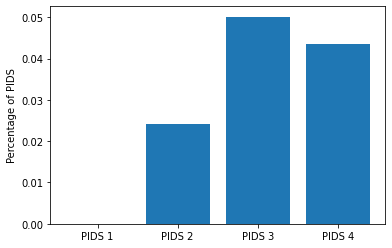

PIDS 3 has the highest percentage


In [147]:
#Mask 1 
SumMask1 = np.sum(PIDS_1, axis=None)
Size1 = sys.getsizeof(PIDS_1)
#Calculate percentage 
PIDSPer1 = SumMask1/Size1 

SumMask2 = np.sum(PIDS_2, axis=None)
Size2 = sys.getsizeof(PIDS_2)
#Calculate percentage 
PIDSPer2 = SumMask2/Size2 

SumMask3 = np.sum(PIDS_3, axis=None)
Size3 = sys.getsizeof(PIDS_3)
#Calculate percentage 
PIDSPer3 = SumMask3/Size3 

SumMask4 = np.sum(PIDS_4, axis=None)
Size4 = sys.getsizeof(PIDS_4)
#Calculate percentage 
PIDSPer4 = SumMask4/Size4 

fig, ax = plt.subplots()
ax.bar([1, 2, 3, 4], [PIDSPer1, PIDSPer2, PIDSPer3, PIDSPer4])
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['PIDS 1', 'PIDS 2', 'PIDS 3', 'PIDS 4'])
ax.set_ylabel('Percentage of PIDS')
plt.show()
max_percentage = max(PIDSPer1, PIDSPer2, PIDSPer3, PIDSPer4)
if max_percentage == PIDSPer1:
    print("PIDS 1 has the highest percentage")
elif max_percentage == PIDSPer2:
    print("PIDS 2 has the highest percentage")
elif max_percentage == PIDSPer3:
    print("PIDS 3 has the highest percentage")
else:
    print("PIDS 4 has the highest percentage")

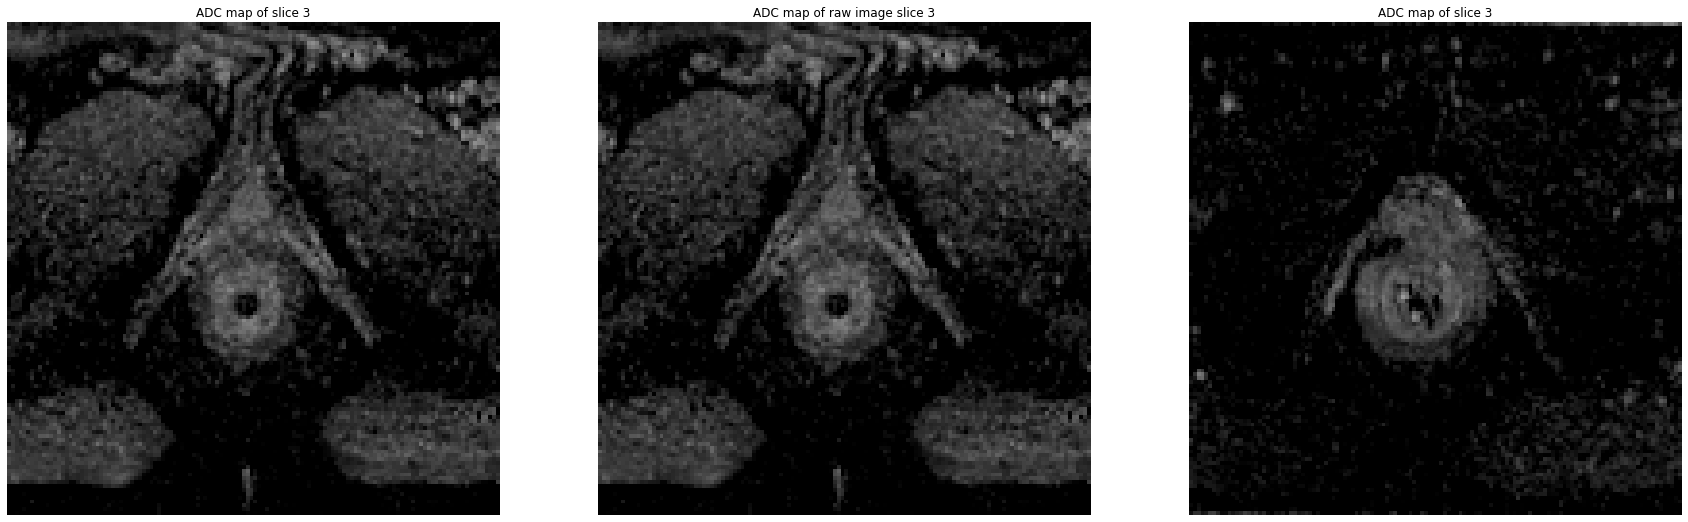

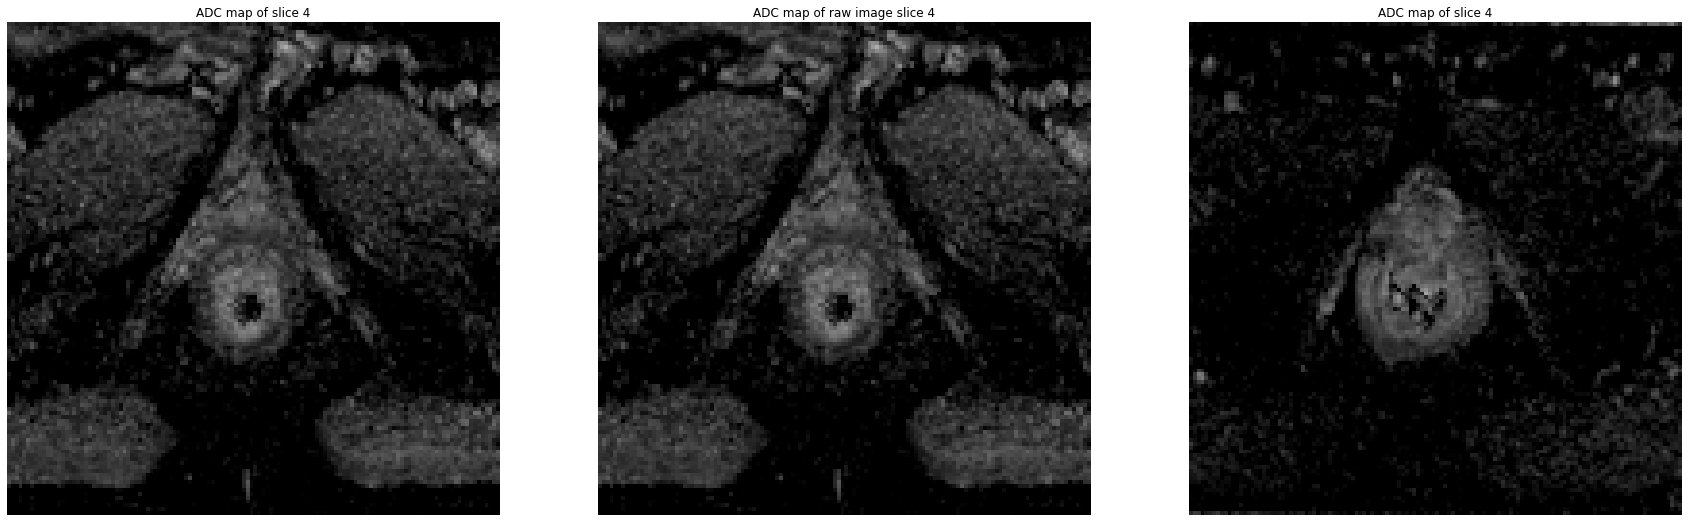

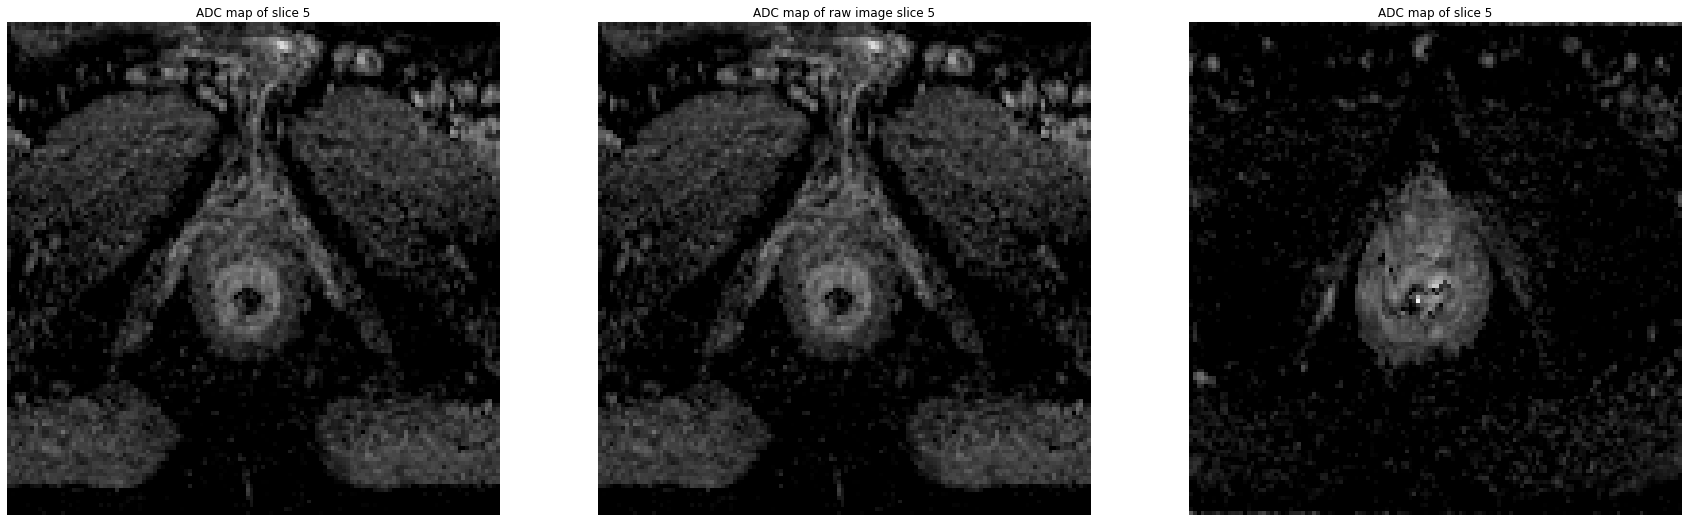

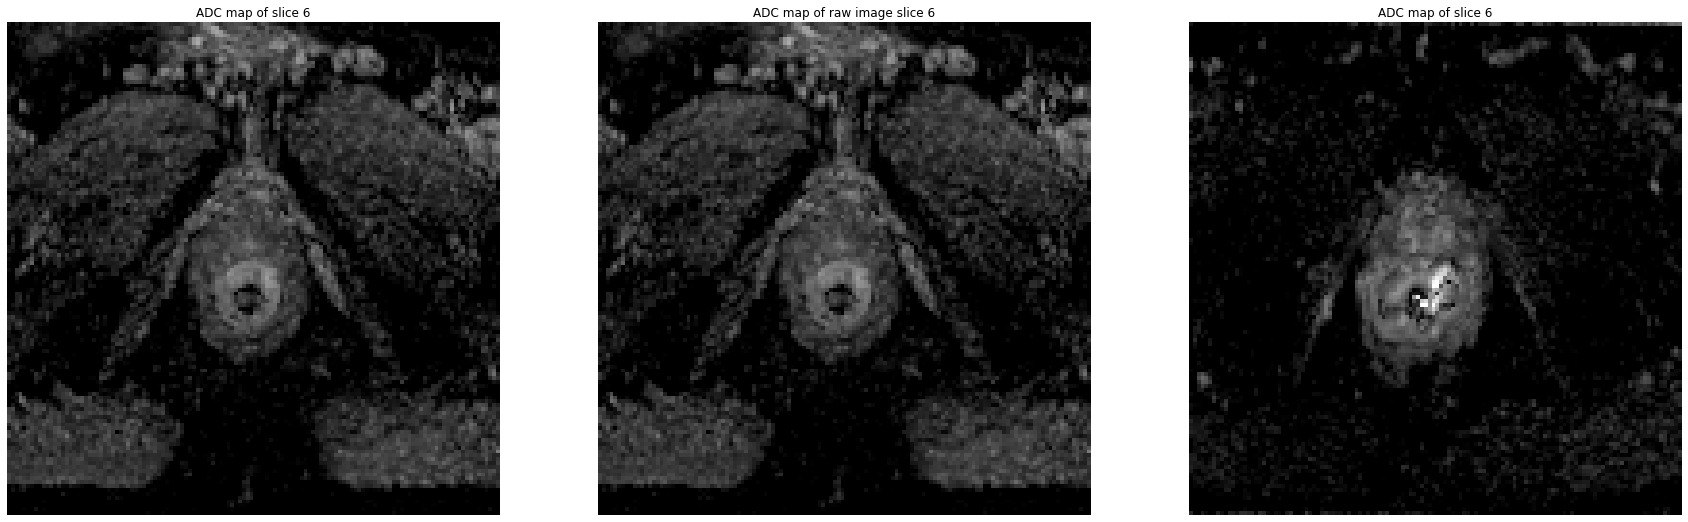

In [148]:
for sliceIndex in range(2,6):#hybrid_data.shape[2]):
    #if np.sum(cancer_mask[:, :, sliceIndex].flatten()):

    slicedata = np.squeeze(hybrid_data[:, :, sliceIndex, :, :])
    adc_map = pf.ADC_slice(b_values, hybrid_data[:,:, sliceIndex, :, 0])
    fig, ax = plt.subplots(1,3, figsize = (30,10))
    ax[0].imshow(adc_map, cmap='gray',vmin=0.3, vmax=3)
    ax[0].set_title(f"ADC map of slice {sliceIndex + 1}")
    ax[0].axis('off')
    

    #slicedata = np.squeeze(hybrid_raw_reshaped[:, :, sliceIndex, :, :])
    #adc_map = pf.ADC_slice(b_values, hybrid_raw_reshaped[:,:, sliceIndex, :, 0])
    
    
    ax[1].imshow(adc_map, cmap='gray',vmin=0.3, vmax=3)
    #slice index = where the cancer is, +2 or +1 
    ax[1].set_title(f"ADC map of raw image slice {sliceIndex + 1}")
    ax[1].axis('off')
    

    slicedata = np.squeeze(registered_hybrid[:, :, sliceIndex, :, :])
    adc_map = pf.ADC_slice(b_values, registered_hybrid[:,:, sliceIndex, :, 0])
    
    ax[2].imshow(adc_map, cmap='gray',vmin=0.3, vmax=3)
    ax[2].set_title(f"ADC map of slice {sliceIndex + 1}")
    ax[2].axis('off')
        
        

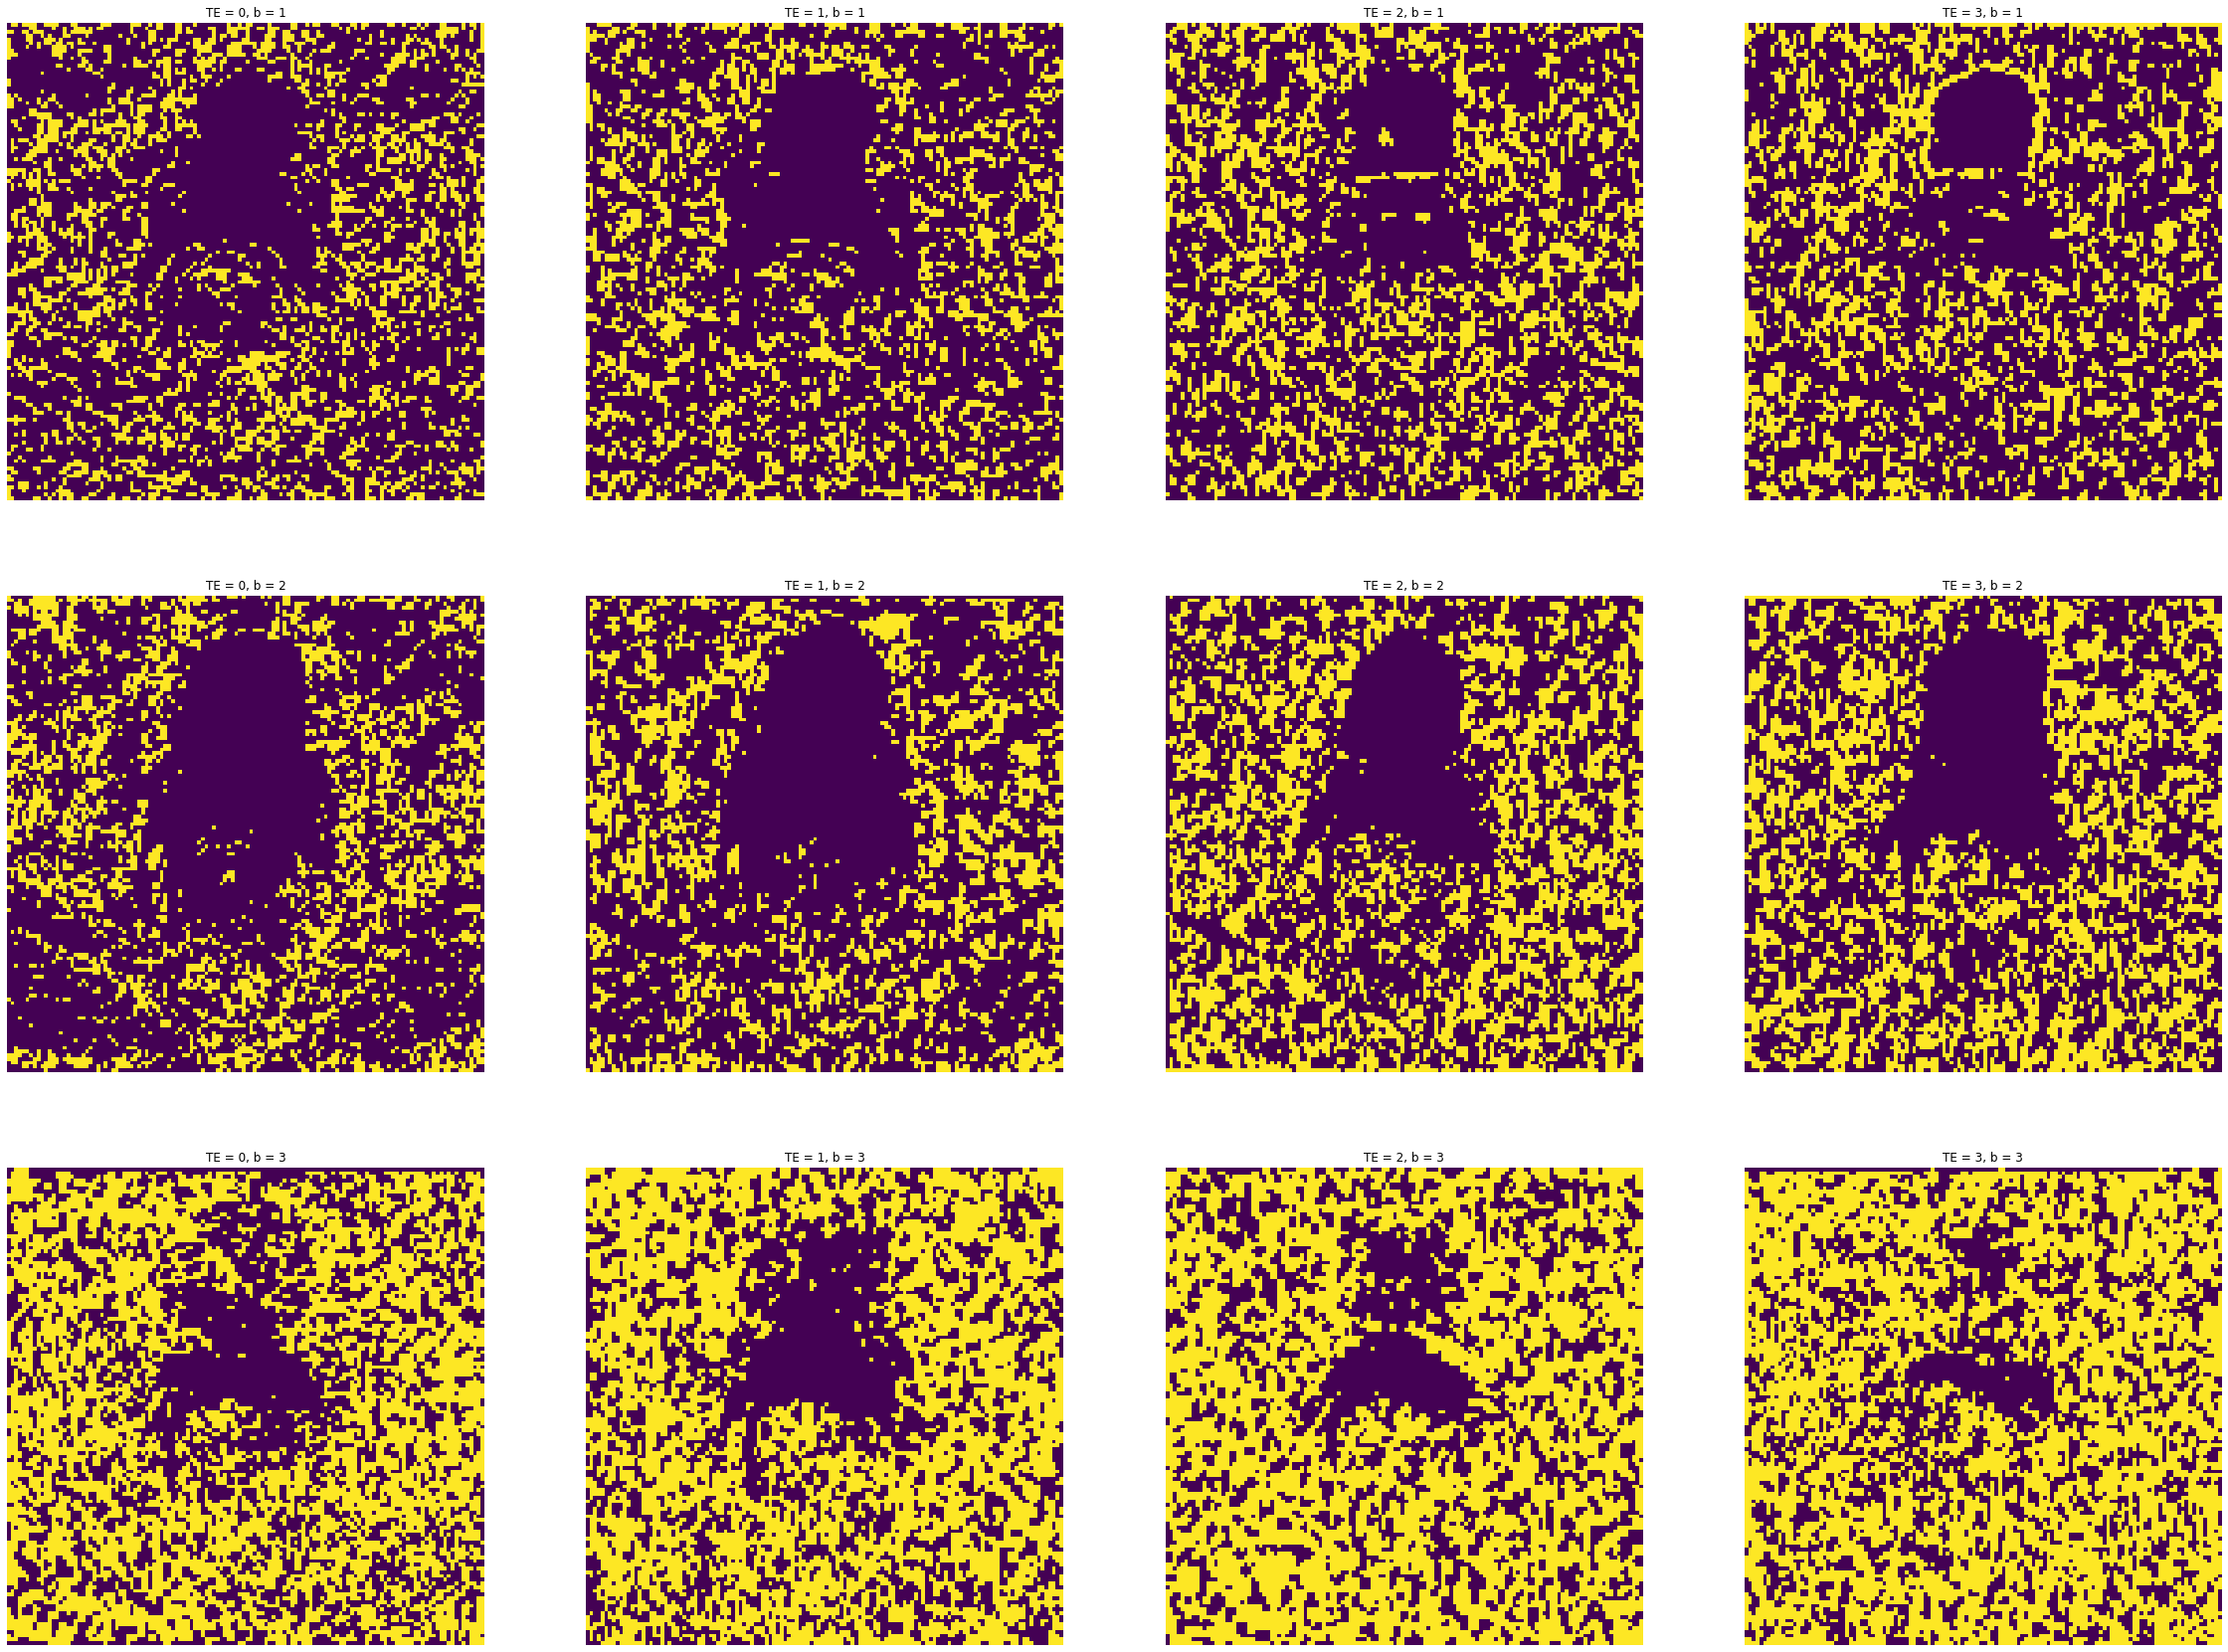

In [149]:
fig, ax = plt.subplots(3,4, figsize = (40,30))
for i in range(PIDS_3.shape[2]):
    for j in range(PIDS_3.shape[3]):
        ax[j][i].imshow(PIDS_3[:, :, i, j])
        ax[j][i].set_title(f"TE = {i}, b = {j+1}")
        ax[j][i].axis('off')


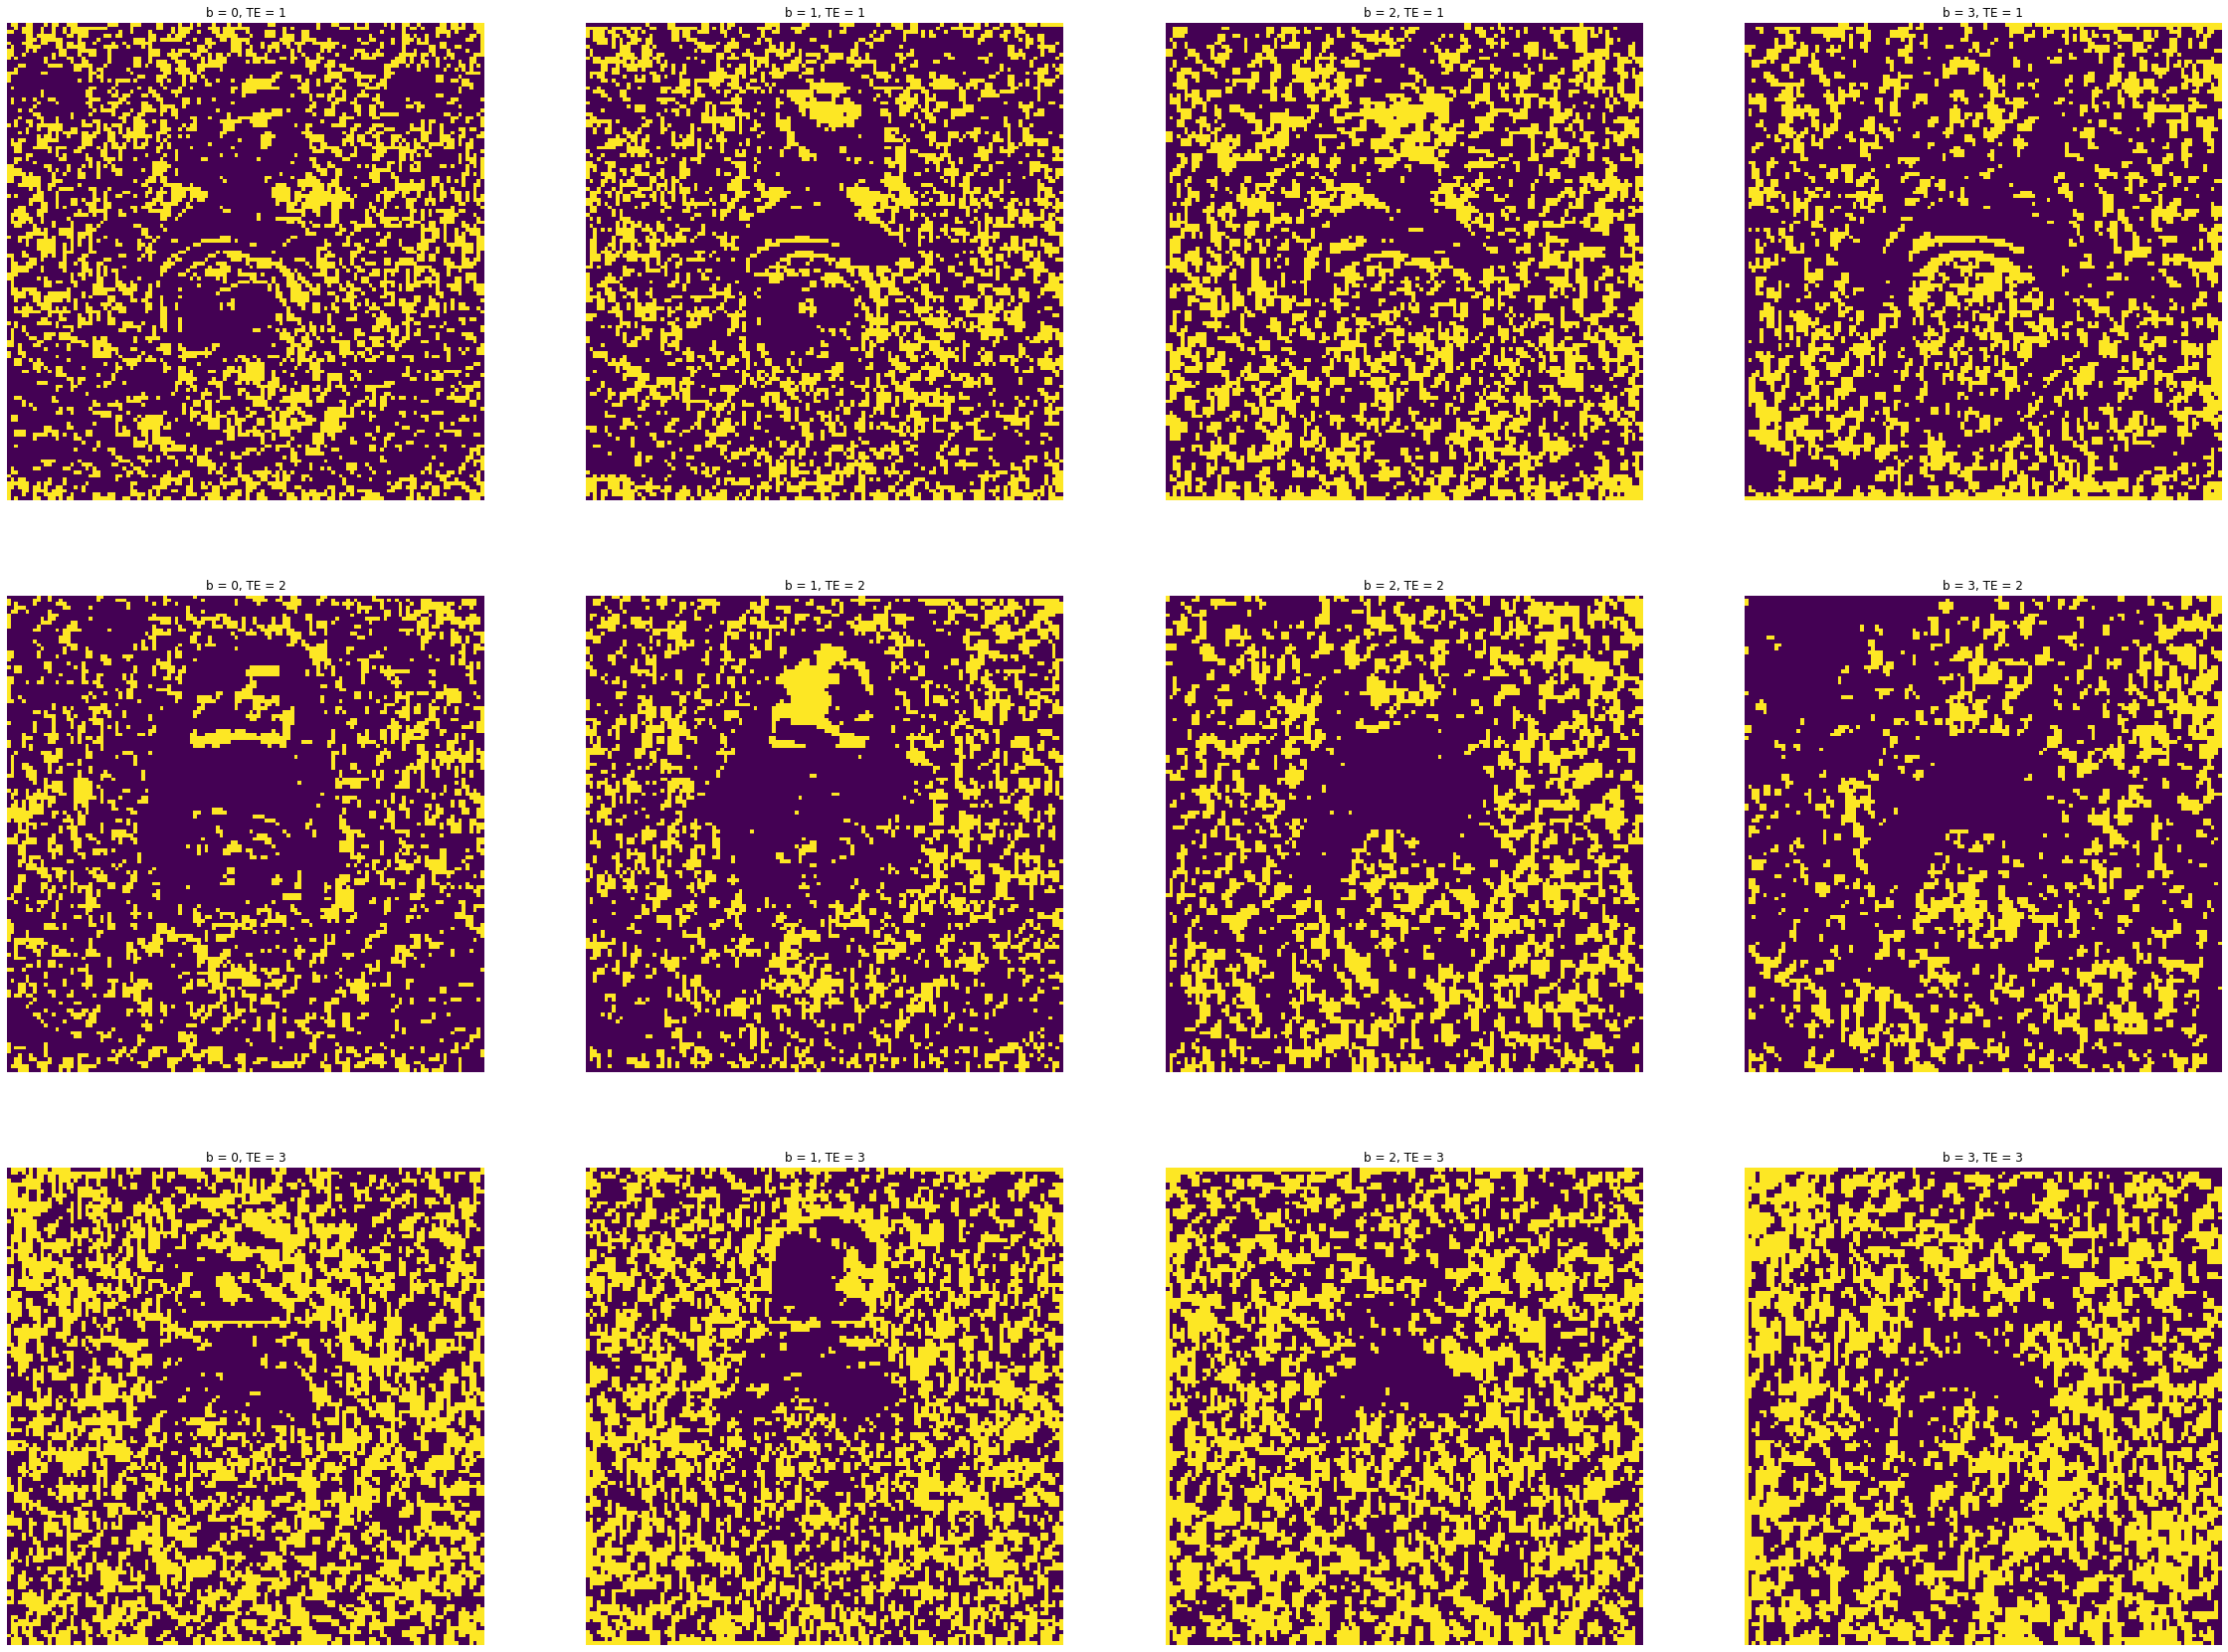

In [150]:

fig, ax = plt.subplots(3,4, figsize = (40,30))
for i in range(PIDS_4.shape[2]):
    for j in range(PIDS_4.shape[3]):
        ax[j][i].imshow(PIDS_4[:, :, i, j])
        ax[j][i].set_title(f"b = {i}, TE = {j+1}")
        ax[j][i].axis('off')

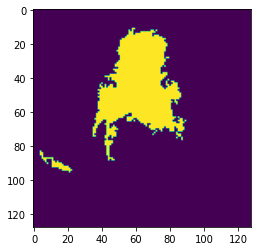

In [151]:
PIDS = PIDS_1.astype(float) + PIDS_2.astype(float)
for i in range(0,3):
     for j in range(0,2):
         PIDS += PIDS_3[:,:,i, j].astype(float)

#min size, connectivity, threshold can be adjusted to get different maps. 
PIDS = 1 - (PIDS>0).astype(float)
PIDS = morphology.remove_small_objects(PIDS.astype(bool), min_size=50, connectivity=50)
PIDS = morphology.remove_small_holes(PIDS, area_threshold=50, connectivity=1)
plt.imshow(PIDS)

